## Transfer Learning for Mask Detection


## Data Understanding
Start with importing all required libraries
* [Tensorflow](https://www.tensorflow.org/): open source Machine Learning (ML) library which is at the core of this notebook. It serves to build and train the Deep Learning (DL) models, More precisely, this is done using the high-level API [Keras](https://www.tensorflow.org/guide/keras/overview), which is integrated into Tensorflow staring with library version 2.0.
* [scikit-learn](https://scikit-learn.org/stable/): Another ML library, but really only useful for classical ML methods. Here, we employ it in the context of evaluation.
* [mlxtend](http://rasbt.github.io/mlxtend/): a contribution by  [Sebastian Raschka](https://sebastianraschka.com/) to extend the possibilities of ML in Python (also see his [Blog](https://sebastianraschka.com/blog/index.html) which is well worth a look).
* [Pillow (PIL)](https://pillow.readthedocs.io/en/stable/): PIL is the acronym for *Python Image Library* and will be used here for displying and processing the image data.
* [matplotlib](https://matplotlib.org/index.html): for visualizations and plots.
* [numpy](https://numpy.org/): a powerful library for scientific (numerical) computing. Tensorflow is built on it and also we will use numpy arrays directly in this notebook.
* [keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications): to import Keras Applications modules for transfer learning as this library provide canned architectures with pre-trained weights.

In [1]:
#import all libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pathlib
import IPython.display as display
import PIL
from PIL import Image
import datetime as dt

In [2]:
#Reproducibility
RSEED = 42
import os
os.environ['PYTHONHASHSEED']=str(RSEED)
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
import random
random.seed(RSEED)
from numpy.random import seed
seed(RSEED)
from tensorflow import random as tfrand
tfrand.set_seed(RSEED)

## Loading the Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Image data is available in the following folder structure:
```
dataset
├───train
│   ├───with_masks
│   └───without_masks
└───valid
    ├───with_masks
    └───without_masks
```

In [4]:
data_dir = pathlib.Path('/content/drive/MyDrive/dataset')
train_image_count = len(list(data_dir.glob('train/*/*')))
valid_image_count = len(list(data_dir.glob('valid/*/*')))
test_image_count = len(list(data_dir.glob('test/*/*')))
print(train_image_count)
print(valid_image_count)
print(test_image_count)

7322
1736
92


In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
CLASS_NAMES

array(['without_masks', 'with_masks'], dtype='<U13')

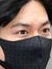

In [ ]:
image_list = list(data_dir.glob('train/with_masks/*'))
display.display(Image.open(str(image_list[4])))

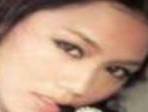

In [ ]:
image_list = list(data_dir.glob('train/without_masks/*'))
display.display(Image.open(str(image_list[4])))

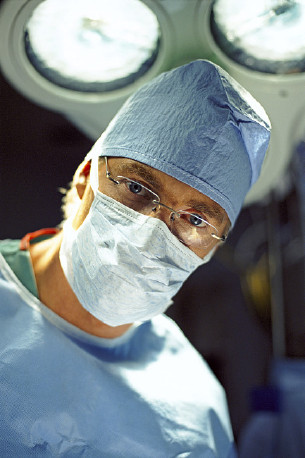

In [ ]:
image_list = list(data_dir.glob('test/with_masks/*'))
display.display(Image.open(str(image_list[1])))

## Data Preparation

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [15]:
#new 
#show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [16]:
# new
#this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_data_gen = training_datagen.flow_from_directory(directory=str(data_dir)+'/train',
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES))
                                                                                     

Found 7322 images belonging to 2 classes.


In [25]:
valid_data_gen = valid_datagen.flow_from_directory(directory=str(data_dir)+'/valid',
                                                   batch_size= BATCH_SIZE,
                                                   shuffle=False,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   classes = list(CLASS_NAMES))

Found 1736 images belonging to 2 classes.


In [26]:
test_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/test',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 92 images belonging to 2 classes.


In [27]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(30,10))
  for n in range(3):
      ax = plt.subplot(BATCH_SIZE//2,BATCH_SIZE//2,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

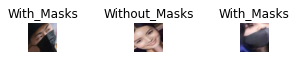

In [28]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

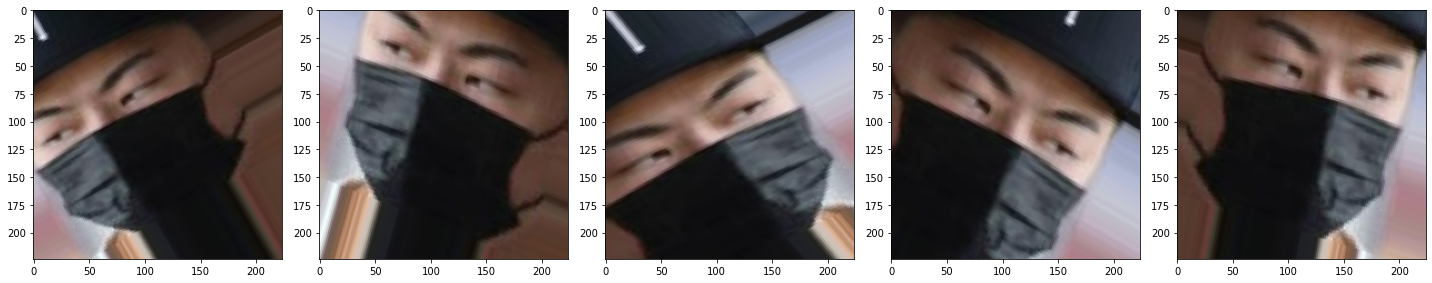

In [29]:
images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(images)

## Modelling

In [51]:
EPOCHS = 10
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(valid_image_count/BATCH_SIZE)
INIT_LR = 1e-4

In [52]:
## load the ResNetV2 network, ensuring the head FC layer sets are left off
baseModel = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, 
                                              input_tensor=Input(shape=(224, 224, 3)))

In [53]:
# constructing the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [54]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [55]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [56]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [57]:
print("[INFO] training head...")
H = model.fit(
    train_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_data_gen,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
193/229 [========================>.....] - ETA: 21s - loss: 0.4577 - accuracy: 0.8259

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


229/229 [==============================] - 169s 708ms/step - loss: 0.4334 - accuracy: 0.8331 - val_loss: 0.2067 - val_accuracy: 0.9055
Epoch 2/10
229/229 [==============================] - 162s 706ms/step - loss: 0.1924 - accuracy: 0.9165 - val_loss: 0.1867 - val_accuracy: 0.9222
Epoch 3/10
229/229 [==============================] - 160s 698ms/step - loss: 0.1622 - accuracy: 0.9273 - val_loss: 0.1882 - val_accuracy: 0.9234
Epoch 4/10
229/229 [==============================] - 160s 698ms/step - loss: 0.1560 - accuracy: 0.9303 - val_loss: 0.1865 - val_accuracy: 0.9297
Epoch 5/10
229/229 [==============================] - 160s 697ms/step - loss: 0.1424 - accuracy: 0.9398 - val_loss: 0.1821 - val_accuracy: 0.9320
Epoch 6/10
229/229 [==============================] - 160s 698ms/step - loss: 0.1367 - accuracy: 0.9430 - val_loss: 0.1981 - val_accuracy: 0.9280
Epoch 7/10
229/229 [==============================] - 167s 729ms/step - loss: 0.1285 - accuracy: 0.9449 - val_loss: 0.1935 - val_accura

In [58]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

## Evaluation

In [59]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(valid_data_gen, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

y_valid = []
for _,labels in valid_data_gen:
    y_valid.extend(list(np.argmax(labels,axis=1)))
    if len(y_valid) == valid_image_count:
        break

# show a nicely formatted classification report
print(classification_report(y_valid, predIdxs,target_names=CLASS_NAMES))


[INFO] evaluating network...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


               precision    recall  f1-score   support

without_masks       0.93      0.95      0.94       868
   with_masks       0.95      0.92      0.93       868

     accuracy                           0.94      1736
    macro avg       0.94      0.94      0.94      1736
 weighted avg       0.94      0.94      0.94      1736



In [60]:
cm = confusion_matrix(y_valid, predIdxs)

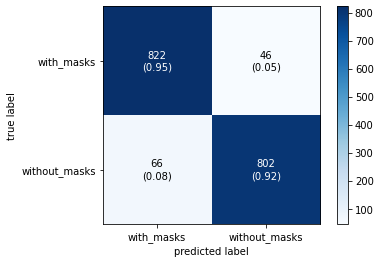

In [61]:
labels = ['with_masks', 'without_masks']
fig, ax = plot_confusion_matrix(conf_mat=cm, 
                                  show_absolute=True,
                                   show_normed=True,
                                   colorbar=True)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.show()

In [63]:
# Saving the model to disk

from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Resnet_model/resnet152v2.h5')